# Loading all the libraries and modules

In [ ]:
!pip install autocorrect
!pip install transformers==3.0.0

     |████████████████████████████████| 624kB 16.8MB/s 
  Created wheel for autocorrect: filename=autocorrect-2.3.0-cp36-none-any.whl size=621588 sha256=c48c6674cd93e9809a394756da5d5b7acd224779a603e6b5da67375cac75ea81
  Stored in directory: /root/.cache/pip/wheels/cc/1c/30/6b0199afbd20eef5959f5eaa0ead86aeef84391740482b2279
Successfully built autocorrect
     |████████████████████████████████| 757kB 19.9MB/s 
     |████████████████████████████████| 890kB 55.1MB/s 
     |████████████████████████████████| 1.2MB 52.3MB/s 
     |████████████████████████████████| 3.0MB 46.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=67626c08e794198d4cf128d903d6ded67932fd28d28895200e93761ef3a483d0
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
from preprocess import Preprocess
from utils import Utils
from google.colab import drive

drive.mount('/content/gdrive')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
Mounted at /content/gdrive


In [ ]:
import time
import numpy as np
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.utils import class_weight

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Embedding, Dense, Flatten, Conv1D, LSTM, Bidirectional, Dropout, BatchNormalization, LayerNormalization, Concatenate 
from tensorflow.keras.layers import AveragePooling1D, MaxPooling1D, GlobalMaxPool1D, GlobalAveragePooling1D, MultiHeadAttention
from tensorflow.keras.layers import LeakyReLU, PReLU, Activation
from tensorflow.keras.optimizers import Adam, Nadam, Adamax, SGD, RMSprop, Adagrad, Adadelta
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
from tensorflow.keras import Model, Sequential

from transformers import TFBertModel, BertConfig, BertTokenizer, TFAutoModel
from transformers import TFDistilBertModel, DistilBertConfig, DistilBertModel, DistilBertTokenizer
from transformers import TFRobertaModel, RobertaConfig, RobertaModel, RobertaTokenizer
from transformers import TFAutoModel, AutoModel, AutoConfig, AutoTokenizer
from transformers import TFAutoModelForSequenceClassification, AutoModelForSequenceClassification, BertForSequenceClassification, TFDistilBertForSequenceClassification

import gc
import warnings
warnings.filterwarnings('ignore')

print("Tensorflow version: ", tf.__version__)

Tensorflow version:  2.4.1


In [ ]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Num GPUs Available:  1
Found GPU at: /device:GPU:0


# Prepare Dataset

In [ ]:
%%time
utils = Utils()
pre = Preprocess(mode="clean")

CPU times: user 3.5 s, sys: 154 ms, total: 3.66 s
Wall time: 3.66 s


In [ ]:
train_data = utils.read_data("/content/gdrive/My Drive/WASSA-2021-Shared-Task/dataset/train/train-empathy-distress-prediction-task-normalized.csv")
print(train_data.shape)
dev_data = utils.read_data("/content/gdrive/My Drive/WASSA-2021-Shared-Task/dataset/dev/dev-empathy-distress-prediction-task-normalized.csv")
print(dev_data.shape)

(1860, 28)
(270, 23)


# Bert Model

In [ ]:
class BertModel():
    """ Implementation of BERT for regression """


    def __init__(self, activation, kr_initializer, kr_rate, bert_model="BERT", output_hidden_states=False):
        """ Constructor to initialize Deep learning models
        @param model (str): the model to be used (DNN, CNN, BiLSTM, BERT, DistilBERT, RoBERTa).
        @param output_hidden_states (bool): Whether to output the hidden states of BERT.
        """
        self.activation = activation
        self.kr_rate=  kr_rate
        self.kr_initializer = kr_initializer
        if bert_model == "BERT":
            config = BertConfig.from_pretrained("bert-base-uncased", output_hidden_states=output_hidden_states)
            self.tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)
            self.bert = TFBertModel.from_pretrained("bert-base-uncased", config=config)

        elif bert_model == "DistilBERT":
            config = DistilBertConfig.from_pretrained("distilbert-base-uncased", output_hidden_states=output_hidden_states)
            self.tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased", do_lower_case=True)
            self.bert = TFDistilBertModel.from_pretrained("distilbert-base-uncased", config=config)

        elif bert_model == "RoBERTa":
            config = RobertaConfig.from_pretrained("roberta-base", output_hidden_states=output_hidden_states)
            self.tokenizer = RobertaTokenizer.from_pretrained("roberta-base", do_lower_case=True)
            self.bert = TFRobertaModel.from_pretrained("roberta-base", config=config)
        elif bert_model == "custom":
            model_name = "cardiffnlp/twitter-roberta-base-sentiment"
            self.tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=True, normalization=True)
            self.bert = TFAutoModel.from_pretrained(model_name)





    def prepare_input(self, corpus, maxlen):
        """ Function to prepare input data for BERT.
        @param corpus (list): Dataset to be processed.
        @param max_len (int): maximum length of input post. Texts longer that max_len will be truncated, while shorter than max_len will be padded.
        """
        input_ids = []
        attention_mask = []

        for record in corpus:
            encoded_text = self.tokenizer.encode_plus(text=record,
                                                      add_special_tokens=True,
                                                      return_attention_mask=True,
                                                      max_length=maxlen,
                                                      pad_to_max_length=True,
                                                      truncation=True)
            input_ids.append(encoded_text.get("input_ids"))
            attention_mask.append(encoded_text.get("attention_mask"))

        return [np.array(input_ids, dtype="int32"), np.array(attention_mask, dtype="int32")]





    def build(self, input_length):
        """ Function to define the forward pass of the model.
        @param input (tensor): input to the model.
        """
        input_ids = Input(shape=(input_length,), name='input_ids', dtype="int32")
        attention_mask = Input(shape=(input_length,), name='attention_mask', dtype="int32")
        x = self.bert(input_ids, attention_mask=attention_mask)[0]
        x = GlobalAveragePooling1D()(x)
        x = Dense(128, activation=self.activation, kernel_initializer=self.kr_initializer, kernel_regularizer=l2(self.kr_rate))(x)
        out = Dropout(0.2)(x)

        model = Model(inputs=[input_ids, attention_mask], outputs=out)
        model.layers[2].trainable = False
        return model



# Class MTLM (0.4772)

In [ ]:
class MTLM():


    # ------------------------------------------------------------ Constructor ------------------------------------------------------------
    
    def __init__(self, base_model_type="CNN", activation="relu", kr_rate=0.001, score_loss="mse", binary_loss="binary_crossentropy", multiclass_loss="sparse_categorical_crossentropy", cpkt="trial"):
        
        self.kr_rate = kr_rate
        # Set the model activation:
        if activation == "leaky_relu":
            self.activation = LeakyReLU()
            self.kr_initializer = tf.keras.initializers.HeUniform()
        elif activation == "paramaterized_leaky_relu":
            self.activation = PReLU() 
            self.kr_initializer = tf.keras.initializers.HeUniform()          
        elif activation == "relu":
            self.activation = "relu"
            self.kr_initializer = tf.keras.initializers.HeUniform()
        else:
            self.activation = activation
            self.kr_initializer  = tf.keras.initializers.GlorotUniform()

        # Set the regression loss:
        self.score_metric = "mean_squared_error"
        if score_loss == "huber":
            delta = 2.0
            self.score_loss = losses.Huber(delta=delta)
        elif score_loss == "log_cosh":
            self.score_loss = "log_cosh"
        elif score_loss == "mean_squared_logarithmic_error":
            self.score_loss = "mean_squared_logarithmic_error"
        elif score_loss == "mae":
            self.score_loss = "mae"
        else:
            self.score_loss = "mse"

        # Set the binary classification loss:
        if binary_loss == "hinge":
            self.binary_loss = "hinge"
            self.binary_activation = "tanh"
        elif binary_loss == "squared_hinge":
            self.binary_loss = "squared_hinge"
            self.binary_activation = "tanh"
        else:
            self.binary_loss = "binary_crossentropy"
            self.binary_activation = "sigmoid"

        # Set the multi-class calssification loss:
        if multiclass_loss == "kld":
            self.multiclass_loss = "kl_divergence"
        else:
            self.multiclass_loss = "sparse_categorical_crossentropy"

        self.base_model_type = base_model_type
        self.bert_models = ["BERT", "DistilBERT", "RoBERTa", "custom"]
        if self.base_model_type in self.bert_models:
            self.base_model = BertModel(self.activation, self.kr_initializer, self.kr_rate, self.base_model_type, output_hidden_states=False)
        elif self.base_model_type == "CNN":
            self.base_model = CNN(self.activation, self.kr_initializer, self.kr_rate)
        elif self.base_model_type == "BiLSTM":
            self.base_model = BiLSTM(self.activation, self.kr_initializer, self.kr_rate)

        self.gender_encoder = LabelEncoder()
        self.education_encoder = LabelEncoder()
        self.race_encoder = LabelEncoder()
        self.emotion_encoder = LabelEncoder()
        self.age_encoder = LabelEncoder()
        
        # ModelCheckPoint Callback:

        if score_loss == "huber":
            cpkt = cpkt + "-{}-{}".format(score_loss, delta)
        else:
            cpkt = cpkt + "-{}".format(score_loss)
        cpkt = cpkt + "-epoch-{epoch:02d}-val-loss-{val_score_output_loss:02f}.h5"
        checkpoint_filepath = "/content/gdrive/My Drive/WASSA-2021-Shared-Task/model-weights/"+ cpkt
        self.model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath,
                                                    save_weights_only=True,
                                                    monitor='val_score_output_loss',
                                                    mode='auto',
                                                    save_freq = 'epoch',
                                                    save_best_only=True)

        # Reduce Learning Rate on Plateau Callback:
        self.reduce_lr_callback = ReduceLROnPlateau(monitor='val_score_output_loss', 
                                                    mode='auto',
                                                    factor=0.2, 
                                                    patience=10, 
                                                    min_lr=0.0005, 
                                                    verbose=1)
        # Early Stopping
        self.early_stopping = EarlyStopping(monitor='val_score_output_loss', 
                                            patience=20,
                                            verbose=1)





    # ------------------------------------------------------------ Function to prepare input for respective models ------------------------------------------------------------
    
    def prepare_input(self, utils_obj, df, maxlen=200, padding_type='post', truncating_type='post', mode="train"):
        # iri_input = df[["iri_perspective_taking", 
        #                 "iri_personal_distress", 
        #                 "iri_fantasy", 
        #                 "iri_empathatic_concern"]].values.tolist()
        # iri_input = np.reshape(iri_input, (len(iri_input), len(iri_input[0])))

        # personality_input = df[["personality_conscientiousness", 
        #                         "personality_openess", 
        #                         "personality_extraversion", 
        #                         "personality_agreeableness", 
        #                         "personality_stability"]].values.tolist()
        # personality_input = np.reshape(personality_input, (len(personality_input), len(personality_input[0])))


        essay = [pre.clean_text(text, remove_stopwords=False, lemmatize=False) for text in df.essay.values.tolist()]
        if self.base_model_type in self.bert_models:
            #return [self.base_model.prepare_input(essay, maxlen), iri_input, personality_input]
            return self.base_model.prepare_input(essay, maxlen)
        else:
            #return [self.base_model.prepare_input(utils_obj, essay, maxlen, padding_type, truncating_type, mode), iri_input, personality_input]
            return self.base_model.prepare_input(utils_obj, essay, maxlen, padding_type, truncating_type, mode)






    # ------------------------------------------------------------ Funciton to prepare model outputs ------------------------------------------------------------
    
    def prepare_output(self,utils,  df, task="empathy", mode="train"):
        emotion = np.reshape(df.gold_emotion.values.tolist(), (len(df), 1))
        gender = np.reshape(df.gender.values.tolist(), (len(df), 1))
        education = np.reshape(df.education.values.tolist(), (len(df), 1))
        race = np.reshape(df.race.values.tolist(), (len(df), 1))
        age = np.reshape(df.age.apply(lambda x: utils.categorize_age(x)).values.tolist(), (len(df), 1))

        if mode == "train":
            emotion = self.emotion_encoder.fit_transform(emotion)
            gender = self.gender_encoder.fit_transform(gender)
            education = self.education_encoder.fit_transform(education)
            age = self.age_encoder.fit_transform(age)
            race = self.race_encoder.fit_transform(race)

        elif mode == "dev" or "test":
            emotion = self.emotion_encoder.transform(emotion)
            gender = self.gender_encoder.transform(gender)
            education = self.education_encoder.transform(education)
            age = self.age_encoder.transform(age)
            race = self.race_encoder.transform(race)

        if task == "empathy":
            score = np.reshape(df.gold_empathy.values.tolist(), (len(df), 1))
            bin = np.reshape(df.gold_empathy_bin.values.tolist(), (len(df), 1))
            return [bin, emotion, gender, education, age, race, score]
        if task == "distress":
            score = np.reshape(df.gold_distress.values.tolist(), (len(df), 1))
            bin = np.reshape(df.gold_distress_bin.values.tolist(), (len(df), 1))
            return[bin, emotion, gender, education, age, race, score]





    # ------------------------------------------------------------ Function to build the model ------------------------------------------------------------
    
    def build(self, embedding_matrix, input_length=100):
        if self.base_model_type in self.bert_models:
            input_ids = Input(shape=(input_length,), name="input_ids")
            attention_mask = Input(shape=(input_length,), name="attention_mask")
            base_output = self.base_model.build(input_length)([input_ids, attention_mask])
        else:
            input = Input(shape=(input_length,), name="base_model_input")
            base_output = self.base_model.build(input_length, embedding_matrix)(input)

        x1 = Dense(32, activation=self.activation, kernel_initializer=self.kr_initializer, kernel_regularizer=l2(self.kr_rate))(base_output)
        bin = Dense(1, activation="sigmoid", name='bin_output')(x1)

        x2 = Dense(32, activation=self.activation, kernel_initializer=self.kr_initializer, kernel_regularizer=l2(self.kr_rate))(base_output)
        emotion = Dense(7, activation='softmax', name='emotion_output')(x2)

        x3 = Dense(32, activation=self.activation, kernel_initializer=self.kr_initializer, kernel_regularizer=l2(self.kr_rate))(base_output)
        gender = Dense(3, activation='softmax', name='gender_output')(x3)
        education = Dense(6, activation='softmax', name='education_output')(x3)
        age = Dense(4, activation='softmax', name='age_output')(x3)
  
        x4 = Dense(32, activation=self.activation, kernel_initializer=self.kr_initializer, kernel_regularizer=l2(self.kr_rate))(base_output)
        race = Dense(6, activation='softmax', name='race_output')(x4)

        x = Concatenate(axis=1)([x1, x2, x3, x4])
        #x = Dropout(0.2)(x)
        x = Dense(16, activation=self.activation, kernel_initializer=self.kr_initializer)(x)
        score = Dense(1, name='score_output')(x)
        
        if self.base_model_type in self.bert_models:
            self.model = Model(inputs=[input_ids, attention_mask], 
                               outputs=[bin, emotion, gender, education, age, race, score])
        else:
            self.model = Model(inputs=input, 
                               outputs=[bin, emotion, gender, education, age, race, score])
        self.model.compile(optimizer=Adam(lr=0.001), 
                           loss={"bin_output":self.binary_loss,                                                           
                                 "emotion_output":self.multiclass_loss,
                                 "gender_output":self.multiclass_loss,
                                 "education_output":self.multiclass_loss,
                                 "age_output":self.multiclass_loss,
                                 "race_output":self.multiclass_loss,
                                 "score_output":self.score_loss},
                           metrics={"score_output":self.score_metric})
        self.model.summary()





    # ------------------------------------------------------------ Function to plot model architecture ------------------------------------------------------------
        
    def plot_model_arch(self):
        return plot_model(self.model, show_shapes=True)





    # ------------------------------------------------------------ Function to train the model ------------------------------------------------------------
    
    def train(self, x_train, y_train, x_val, y_val, epochs=200, batch_size=32):
        history = self.model.fit(x_train,
                                 y_train, 
                                 epochs=epochs, 
                                 batch_size=batch_size, 
                                 verbose=1, 
                                 validation_data = (x_val, y_val),
                                 callbacks=[self.model_checkpoint_callback, self.reduce_lr_callback, self.early_stopping])
        return history





    # ------------------------------------------------------------ Function to predict model output ------------------------------------------------------------
    
    def prediction(self, val_essay, model_path=""):
        model_path = "/content/gdrive/My Drive/WASSA-2021-Shared-Task/best-models/"+model_path
        self.model.load_weights(model_path)
        pred = self.model.predict(val_essay)
        return pred[-1]





    # ------------------------------------------------------------ Function to calculate the Pearson's correlation ------------------------------------------------------------
    
    def compute_correlation(self, y_true, y_pred):
        y_pred = y_pred.flatten()
        y_true = y_true.flatten()
        return pearsonr(y_true, y_pred)
        
        


    # ------------------------------------------------------------ Function to calculate the Mean Squared Error ------------------------------------------------------------
       
    def compute_mse(self, y_true, y_pred):
        return np.average(losses.mean_squared_error(y_true, y_pred))




    # ------------------------------------------------------------ Function to plot model loss ------------------------------------------------------------
    
    def plot_curves(self, history):
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train','validation'], loc='upper left')
        plt.show() 

# Class MTLM (0.4873)

In [ ]:
class MTLM():


    # ------------------------------------------------------------ Constructor ------------------------------------------------------------
    
    def __init__(self, base_model_type="CNN", activation="relu", kr_rate=0.001, score_loss="mse", binary_loss="binary_crossentropy", multiclass_loss="sparse_categorical_crossentropy", cpkt="trial"):
        
        self.kr_rate = kr_rate
        # Set the model activation:
        if activation == "leaky_relu":
            self.activation = LeakyReLU()
            self.kr_initializer = tf.keras.initializers.HeUniform()
        elif activation == "paramaterized_leaky_relu":
            self.activation = PReLU() 
            self.kr_initializer = tf.keras.initializers.HeUniform()          
        elif activation == "relu":
            self.activation = "relu"
            self.kr_initializer = tf.keras.initializers.HeUniform()
        else:
            self.activation = activation
            self.kr_initializer  = tf.keras.initializers.GlorotUniform()

        # Set the regression loss:
        self.score_metric = "mean_squared_error"
        if score_loss == "huber":
            delta = 2.0
            self.score_loss = losses.Huber(delta=delta)
        elif score_loss == "log_cosh":
            self.score_loss = "log_cosh"
        elif score_loss == "mean_squared_logarithmic_error":
            self.score_loss = "mean_squared_logarithmic_error"
        elif score_loss == "mae":
            self.score_loss = "mae"
        else:
            self.score_loss = "mse"

        # Set the binary classification loss:
        if binary_loss == "hinge":
            self.binary_loss = "hinge"
            self.binary_activation = "tanh"
        elif binary_loss == "squared_hinge":
            self.binary_loss = "squared_hinge"
            self.binary_activation = "tanh"
        else:
            self.binary_loss = "binary_crossentropy"
            self.binary_activation = "sigmoid"

        # Set the multi-class calssification loss:
        if multiclass_loss == "kld":
            self.multiclass_loss = "kl_divergence"
        else:
            self.multiclass_loss = "sparse_categorical_crossentropy"

        self.base_model_type = base_model_type
        self.bert_models = ["BERT", "DistilBERT", "RoBERTa", "custom"]
        if self.base_model_type in self.bert_models:
            self.base_model = BertModel(self.activation, self.kr_initializer, self.kr_rate, self.base_model_type, output_hidden_states=False)
        elif self.base_model_type == "CNN":
            self.base_model = CNN(self.activation, self.kr_initializer, self.kr_rate)
        elif self.base_model_type == "BiLSTM":
            self.base_model = BiLSTM(self.activation, self.kr_initializer, self.kr_rate)

        self.gender_encoder = LabelEncoder()
        self.education_encoder = LabelEncoder()
        self.race_encoder = LabelEncoder()
        self.emotion_encoder = LabelEncoder()
        self.age_encoder = LabelEncoder()
        
        # ModelCheckPoint Callback:

        if score_loss == "huber":
            cpkt = cpkt + "-{}-{}".format(score_loss, delta)
        else:
            cpkt = cpkt + "-{}".format(score_loss)
        cpkt = cpkt + "-epoch-{epoch:02d}-val-loss-{val_score_output_loss:02f}.h5"
        checkpoint_filepath = "/content/gdrive/My Drive/WASSA-2021-Shared-Task/model-weights/"+ cpkt
        self.model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath,
                                                    save_weights_only=True,
                                                    monitor='val_score_output_loss',
                                                    mode='auto',
                                                    save_freq = 'epoch',
                                                    save_best_only=True)

        # Reduce Learning Rate on Plateau Callback:
        self.reduce_lr_callback = ReduceLROnPlateau(monitor='val_score_output_loss', 
                                                    mode='auto',
                                                    factor=0.2, 
                                                    patience=10, 
                                                    min_lr=0.0005, 
                                                    verbose=1)
        # Early Stopping
        self.early_stopping = EarlyStopping(monitor='val_score_output_loss', 
                                            patience=20,
                                            verbose=1)





    # ------------------------------------------------------------ Function to prepare input for respective models ------------------------------------------------------------
    
    def prepare_input(self, utils_obj, df, maxlen=200, padding_type='post', truncating_type='post', mode="train"):
        # iri_input = df[["iri_perspective_taking", 
        #                 "iri_personal_distress", 
        #                 "iri_fantasy", 
        #                 "iri_empathatic_concern"]].values.tolist()
        # iri_input = np.reshape(iri_input, (len(iri_input), len(iri_input[0])))

        # personality_input = df[["personality_conscientiousness", 
        #                         "personality_openess", 
        #                         "personality_extraversion", 
        #                         "personality_agreeableness", 
        #                         "personality_stability"]].values.tolist()
        # personality_input = np.reshape(personality_input, (len(personality_input), len(personality_input[0])))


        essay = [pre.clean_text(text, remove_stopwords=False, lemmatize=False) for text in df.essay.values.tolist()]
        if self.base_model_type in self.bert_models:
            #return [self.base_model.prepare_input(essay, maxlen), iri_input, personality_input]
            return self.base_model.prepare_input(essay, maxlen)
        else:
            #return [self.base_model.prepare_input(utils_obj, essay, maxlen, padding_type, truncating_type, mode), iri_input, personality_input]
            return self.base_model.prepare_input(utils_obj, essay, maxlen, padding_type, truncating_type, mode)






    # ------------------------------------------------------------ Funciton to prepare model outputs ------------------------------------------------------------
    
    def prepare_output(self,utils,  df, task="empathy", mode="train"):
        emotion = np.reshape(df.gold_emotion.values.tolist(), (len(df), 1))
        gender = np.reshape(df.gender.values.tolist(), (len(df), 1))
        education = np.reshape(df.education.values.tolist(), (len(df), 1))
        race = np.reshape(df.race.values.tolist(), (len(df), 1))
        age = np.reshape(df.age.apply(lambda x: utils.categorize_age(x)).values.tolist(), (len(df), 1))

        if mode == "train":
            emotion = self.emotion_encoder.fit_transform(emotion)
            gender = self.gender_encoder.fit_transform(gender)
            education = self.education_encoder.fit_transform(education)
            #age = self.age_encoder.fit_transform(age)
            race = self.race_encoder.fit_transform(race)

        elif mode == "dev" or "test":
            emotion = self.emotion_encoder.transform(emotion)
            gender = self.gender_encoder.transform(gender)
            education = self.education_encoder.transform(education)
            #age = self.age_encoder.transform(age)
            race = self.race_encoder.transform(race)

        if task == "empathy":
            score = np.reshape(df.gold_empathy.values.tolist(), (len(df), 1))
            bin = np.reshape(df.gold_empathy_bin.values.tolist(), (len(df), 1))
            return [bin, emotion, gender, education, race, score]
        if task == "distress":
            score = np.reshape(df.gold_distress.values.tolist(), (len(df), 1))
            bin = np.reshape(df.gold_distress_bin.values.tolist(), (len(df), 1))
            return[bin, emotion, gender, education, race, score]





    # ------------------------------------------------------------ Function to build the model ------------------------------------------------------------
    
    def build(self, embedding_matrix, input_length=100):
        if self.base_model_type in self.bert_models:
            input_ids = Input(shape=(input_length,), name="input_ids")
            attention_mask = Input(shape=(input_length,), name="attention_mask")
            base_output = self.base_model.build(input_length)([input_ids, attention_mask])
        else:
            input = Input(shape=(input_length,), name="base_model_input")
            base_output = self.base_model.build(input_length, embedding_matrix)(input)

        x1 = Dense(32, activation=self.activation, kernel_initializer=self.kr_initializer, kernel_regularizer=l2(self.kr_rate))(base_output)
        bin = Dense(1, activation="sigmoid", name='bin_output')(x1)

        x2 = Dense(32, activation=self.activation, kernel_initializer=self.kr_initializer, kernel_regularizer=l2(self.kr_rate))(base_output)
        emotion = Dense(7, activation='softmax', name='emotion_output')(x2)

        x3 = Dense(32, activation=self.activation, kernel_initializer=self.kr_initializer, kernel_regularizer=l2(self.kr_rate))(base_output)
        gender = Dense(3, activation='softmax', name='gender_output')(x3)
        
        x4 = Dense(32, activation=self.activation, kernel_initializer=self.kr_initializer, kernel_regularizer=l2(self.kr_rate))(base_output)
        education = Dense(6, activation='softmax', name='education_output')(x4)
  
        x5 = Dense(32, activation=self.activation, kernel_initializer=self.kr_initializer, kernel_regularizer=l2(self.kr_rate))(base_output)
        race = Dense(6, activation='softmax', name='race_output')(x5)

        x = Concatenate(axis=1)([x1, x2, x3, x4, x5])
        #x = Dropout(0.2)(x)
        x = Dense(16, activation=self.activation, kernel_initializer=self.kr_initializer)(x)
        score = Dense(1, name='score_output')(x)
        
        if self.base_model_type in self.bert_models:
            self.model = Model(inputs=[input_ids, attention_mask], 
                               outputs=[bin, emotion, gender, education, race, score])
        else:
            self.model = Model(inputs=input, 
                               outputs=[bin, emotion, gender, education, race, score])
        self.model.compile(optimizer=Adam(lr=0.001), 
                           loss={"bin_output":self.binary_loss,                                                           
                                 "emotion_output":self.multiclass_loss,
                                 "gender_output":self.multiclass_loss,
                                 "education_output":self.multiclass_loss,
                                 "race_output":self.multiclass_loss,
                                 "score_output":self.score_loss},
                           metrics={"score_output":self.score_metric})
        self.model.summary()





    # ------------------------------------------------------------ Function to plot model architecture ------------------------------------------------------------
        
    def plot_model_arch(self):
        return plot_model(self.model, show_shapes=True)





    # ------------------------------------------------------------ Function to train the model ------------------------------------------------------------
    
    def train(self, x_train, y_train, x_val, y_val, epochs=200, batch_size=32):
        history = self.model.fit(x_train,
                                 y_train, 
                                 epochs=epochs, 
                                 batch_size=batch_size, 
                                 verbose=1, 
                                 validation_data = (x_val, y_val),
                                 callbacks=[self.model_checkpoint_callback, self.reduce_lr_callback, self.early_stopping])
        return history





    # ------------------------------------------------------------ Function to predict model output ------------------------------------------------------------
    
    def prediction(self, val_essay, model_path=""):
        model_path = "/content/gdrive/My Drive/WASSA-2021-Shared-Task/model-weights/"+model_path
        self.model.load_weights(model_path)
        pred = self.model.predict(val_essay)
        return pred[-1]





    # ------------------------------------------------------------ Function to calculate the Pearson's correlation ------------------------------------------------------------
    
    def compute_correlation(self, y_true, y_pred):
        y_pred = y_pred.flatten()
        y_true = y_true.flatten()
        return pearsonr(y_true, y_pred)
        
        


    # ------------------------------------------------------------ Function to calculate the Mean Squared Error ------------------------------------------------------------
       
    def compute_mse(self, y_true, y_pred):
        return np.average(losses.mean_squared_error(y_true, y_pred))




    # ------------------------------------------------------------ Function to plot model loss ------------------------------------------------------------
    
    def plot_curves(self, history):
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train','validation'], loc='upper left')
        plt.show() 

# Trial Class MTLM

In [ ]:
class MTLM():


    # ------------------------------------------------------------ Constructor ------------------------------------------------------------
    
    def __init__(self, base_model_type="CNN", activation="relu", kr_rate=0.001, score_loss="mse", binary_loss="binary_crossentropy", multiclass_loss="sparse_categorical_crossentropy", cpkt="trial"):
        
        self.kr_rate = kr_rate
        # Set the model activation:
        if activation == "leaky_relu":
            self.activation = LeakyReLU()
            self.kr_initializer = tf.keras.initializers.HeUniform()
        elif activation == "paramaterized_leaky_relu":
            self.activation = PReLU() 
            self.kr_initializer = tf.keras.initializers.HeUniform()          
        elif activation == "relu":
            self.activation = "relu"
            self.kr_initializer = tf.keras.initializers.HeUniform()
        else:
            self.activation = activation
            self.kr_initializer  = tf.keras.initializers.GlorotUniform()

        # Set the regression loss:
        self.score_metric = "mean_squared_error"
        if score_loss == "huber":
            delta = 2.0
            self.score_loss = losses.Huber(delta=delta)
        elif score_loss == "log_cosh":
            self.score_loss = "log_cosh"
        elif score_loss == "mean_squared_logarithmic_error":
            self.score_loss = "mean_squared_logarithmic_error"
        elif score_loss == "mae":
            self.score_loss = "mae"
        else:
            self.score_loss = "mse"

        # Set the binary classification loss:
        if binary_loss == "hinge":
            self.binary_loss = "hinge"
            self.binary_activation = "tanh"
        elif binary_loss == "squared_hinge":
            self.binary_loss = "squared_hinge"
            self.binary_activation = "tanh"
        else:
            self.binary_loss = "binary_crossentropy"
            self.binary_activation = "sigmoid"

        # Set the multi-class calssification loss:
        if multiclass_loss == "kld":
            self.multiclass_loss = "kl_divergence"
        else:
            self.multiclass_loss = "sparse_categorical_crossentropy"

        self.base_model_type = base_model_type
        self.bert_models = ["BERT", "DistilBERT", "RoBERTa", "custom"]
        if self.base_model_type in self.bert_models:
            self.base_model = BertModel(self.activation, self.kr_initializer, self.kr_rate, self.base_model_type, output_hidden_states=False)
        elif self.base_model_type == "CNN":
            self.base_model = CNN(self.activation, self.kr_initializer, self.kr_rate)
        elif self.base_model_type == "BiLSTM":
            self.base_model = BiLSTM(self.activation, self.kr_initializer, self.kr_rate)

        self.gender_encoder = LabelEncoder()
        self.education_encoder = LabelEncoder()
        self.race_encoder = LabelEncoder()
        self.emotion_encoder = LabelEncoder()
        self.age_encoder = LabelEncoder()
        
        # ModelCheckPoint Callback:

        if score_loss == "huber":
            cpkt = cpkt + "-{}-{}".format(score_loss, delta)
        else:
            cpkt = cpkt + "-{}".format(score_loss)
        cpkt = cpkt + "-epoch-{epoch:02d}-val-loss-{val_score_output_loss:02f}.h5"
        checkpoint_filepath = "/content/gdrive/My Drive/WASSA-2021-Shared-Task/model-weights/"+ cpkt
        self.model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath,
                                                    save_weights_only=True,
                                                    monitor='val_score_output_loss',
                                                    mode='auto',
                                                    save_freq = 'epoch',
                                                    save_best_only=True)

        # Reduce Learning Rate on Plateau Callback:
        self.reduce_lr_callback = ReduceLROnPlateau(monitor='val_score_output_loss', 
                                                    mode='auto',
                                                    factor=0.2, 
                                                    patience=10, 
                                                    min_lr=0.0005, 
                                                    verbose=1)
        # Early Stopping
        self.early_stopping = EarlyStopping(monitor='val_score_output_loss', 
                                            patience=20,
                                            verbose=1)





    # ------------------------------------------------------------ Function to prepare input for respective models ------------------------------------------------------------
    
    def prepare_input(self, utils_obj, df, maxlen=200, padding_type='post', truncating_type='post', mode="train"):
        # iri_input = df[["iri_perspective_taking", 
        #                 "iri_personal_distress", 
        #                 "iri_fantasy", 
        #                 "iri_empathatic_concern"]].values.tolist()
        # iri_input = np.reshape(iri_input, (len(iri_input), len(iri_input[0])))

        # personality_input = df[["personality_conscientiousness", 
        #                         "personality_openess", 
        #                         "personality_extraversion", 
        #                         "personality_agreeableness", 
        #                         "personality_stability"]].values.tolist()
        # personality_input = np.reshape(personality_input, (len(personality_input), len(personality_input[0])))

        essay = [pre.clean_text(text, remove_stopwords=False, lemmatize=False) for text in df.essay.values.tolist()]
        senti_scores = [TextBlob(text).sentiment[0:] for text in essay]
        senti_scores = np.array([*senti_scores])
        if self.base_model_type in self.bert_models:
            #return [self.base_model.prepare_input(essay, maxlen), iri_input, personality_input]
            return [self.base_model.prepare_input(essay, maxlen), senti_scores]
        else:
            #return [self.base_model.prepare_input(utils_obj, essay, maxlen, padding_type, truncating_type, mode), iri_input, personality_input]
            return [self.base_model.prepare_input(utils_obj, essay, maxlen, padding_type, truncating_type, mode), senti_scores]






    # ------------------------------------------------------------ Funciton to prepare model outputs ------------------------------------------------------------
    
    def prepare_output(self,utils,  df, task="empathy", mode="train"):
        emotion = np.reshape(df.gold_emotion.values.tolist(), (len(df), 1))
        gender = np.reshape(df.gender.values.tolist(), (len(df), 1))
        education = np.reshape(df.education.values.tolist(), (len(df), 1))
        race = np.reshape(df.race.values.tolist(), (len(df), 1))
        age = np.reshape(df.age.apply(lambda x: utils.categorize_age(x)).values.tolist(), (len(df), 1))

        if mode == "train":
            emotion = self.emotion_encoder.fit_transform(emotion)
            gender = self.gender_encoder.fit_transform(gender)
            education = self.education_encoder.fit_transform(education)
            #age = self.age_encoder.fit_transform(age)
            race = self.race_encoder.fit_transform(race)

        elif mode == "dev" or "test":
            emotion = self.emotion_encoder.transform(emotion)
            gender = self.gender_encoder.transform(gender)
            education = self.education_encoder.transform(education)
            #age = self.age_encoder.transform(age)
            race = self.race_encoder.transform(race)

        if task == "empathy":
            score = np.reshape(df.gold_empathy.values.tolist(), (len(df), 1))
            bin = np.reshape(df.gold_empathy_bin.values.tolist(), (len(df), 1))
            return [bin, emotion, gender, education, race, score]
        if task == "distress":
            score = np.reshape(df.gold_distress.values.tolist(), (len(df), 1))
            bin = np.reshape(df.gold_distress_bin.values.tolist(), (len(df), 1))
            return[bin, emotion, gender, education, race, score]





    # ------------------------------------------------------------ Function to build the model ------------------------------------------------------------
    
    def build(self, embedding_matrix, input_length=100):
        if self.base_model_type in self.bert_models:
            input_ids = Input(shape=(input_length,), name="input_ids")
            attention_mask = Input(shape=(input_length,), name="attention_mask")
            base_output = self.base_model.build(input_length)([input_ids, attention_mask])
        else:
            input = Input(shape=(input_length,), name="base_model_input")
            base_output = self.base_model.build(input_length, embedding_matrix)(input)

        x1 = Dense(16, activation=self.activation, kernel_initializer=self.kr_initializer, kernel_regularizer=l2(self.kr_rate))(base_output)
        bin = Dense(1, activation="sigmoid", name='bin_output')(x1)

        senti_input = Input(shape=(2,))
        senti_dense = Dense(2, activation=self.activation, kernel_initializer=self.kr_initializer)(senti_input)
        x2 = Dense(16, activation=self.activation, kernel_initializer=self.kr_initializer, kernel_regularizer=l2(self.kr_rate))(base_output)
        x2 = Concatenate(axis=1)([x2, senti_dense])        
        emotion = Dense(7, activation='softmax', name='emotion_output')(x2)

        x3 = Dense(16, activation=self.activation, kernel_initializer=self.kr_initializer, kernel_regularizer=l2(self.kr_rate))(base_output)
        gender = Dense(3, activation='softmax', name='gender_output')(x3)
        
        x4 = Dense(16, activation=self.activation, kernel_initializer=self.kr_initializer, kernel_regularizer=l2(self.kr_rate))(base_output)
        education = Dense(6, activation='softmax', name='education_output')(x4)
  
        x5 = Dense(16, activation=self.activation, kernel_initializer=self.kr_initializer, kernel_regularizer=l2(self.kr_rate))(base_output)
        race = Dense(6, activation='softmax', name='race_output')(x5)

        x = Concatenate(axis=1)([x1, x2, x3, x4, x5])
        x = Dense(16, activation=self.activation, kernel_initializer=self.kr_initializer)(x)
        score = Dense(1, name='score_output')(x)
        
        if self.base_model_type in self.bert_models:
            self.model = Model(inputs=[input_ids, attention_mask, senti_input], 
                               outputs=[bin, emotion, gender, education, race, score])
        else:
            self.model = Model(inputs=[input, senti_input], 
                               outputs=[bin, emotion, gender, education, race, score])
        self.model.compile(optimizer=Adam(lr=0.001), 
                           loss={"bin_output":self.binary_loss,                                                           
                                 "emotion_output":self.multiclass_loss,
                                 "gender_output":self.multiclass_loss,
                                 "education_output":self.multiclass_loss,
                                 "race_output":self.multiclass_loss,
                                 "score_output":self.score_loss},
                        #    loss_weights={"bin_output": 1.0,                                                           
                        #                  "emotion_output": 0.2,
                        #                  "gender_output": 0.2,
                        #                  "education_output": 0.2,
                        #                  "race_output": 0.2,
                        #                  "score_output": 1.0},
                           metrics={"score_output":self.score_metric})
        self.model.summary()





    # ------------------------------------------------------------ Function to plot model architecture ------------------------------------------------------------
        
    def plot_model_arch(self):
        return plot_model(self.model, show_shapes=True)





    # ------------------------------------------------------------ Function to train the model ------------------------------------------------------------
    
    def train(self, x_train, y_train, x_val, y_val, epochs=200, batch_size=32):
        history = self.model.fit(x_train,
                                 y_train, 
                                 epochs=epochs, 
                                 batch_size=batch_size, 
                                 verbose=1, 
                                 validation_data = (x_val, y_val),
                                 callbacks=[self.model_checkpoint_callback, self.reduce_lr_callback, self.early_stopping])
        return history





    # ------------------------------------------------------------ Function to predict model output ------------------------------------------------------------
    
    def prediction(self, val_essay, model_path=""):
        model_path = "/content/gdrive/My Drive/WASSA-2021-Shared-Task/model-weights/"+model_path
        self.model.load_weights(model_path)
        pred = self.model.predict(val_essay)
        return pred[-1]





    # ------------------------------------------------------------ Function to calculate the Pearson's correlation ------------------------------------------------------------
    
    def compute_correlation(self, y_true, y_pred):
        y_pred = y_pred.flatten()
        y_true = y_true.flatten()
        return pearsonr(y_true, y_pred)
        
        


    # ------------------------------------------------------------ Function to calculate the Mean Squared Error ------------------------------------------------------------
       
    def compute_mse(self, y_true, y_pred):
        return np.average(losses.mean_squared_error(y_true, y_pred))




    # ------------------------------------------------------------ Function to plot model loss ------------------------------------------------------------
    
    def plot_curves(self, history):
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train','validation'], loc='upper left')
        plt.show() 

# Run Multi-task learning model

In [ ]:
%%time
myModel = MTLM(base_model_type="RoBERTa",
               cpkt="old-empathy-bin-1-emotion-gender-edu-race-16-senti-2-score-1-16-RoBERTa-avg-128-kr-0005",
               activation="tanh",
               kr_rate=0.0005,
               score_loss="mse")

Some weights of the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFRobertaModel for predictions without further training.


CPU times: user 867 ms, sys: 372 ms, total: 1.24 s
Wall time: 19.2 s


# For normal DL models

In [ ]:
%%time
prepared_train_essay, myTokenizer = myModel.prepare_input(utils,
                                                          train_essay, 
                                                          maxlen=200, 
                                                          padding_type='post', 
                                                          truncating_type='post', 
                                                          mode="train")
print(prepared_train_essay.shape)
vocab = list(myTokenizer.word_index.keys())
print(len(vocab))

In [ ]:
%%time
prepared_dev_essay = myModel.prepare_input(utils,
                                           dev_essay, 
                                           maxlen=200, 
                                           padding_type='post', 
                                           truncating_type='post', 
                                           mode="test")
print(prepared_dev_essay.shape)

In [ ]:
%%time
embedding_matrix = utils.get_embedding_matrix("/content/gdrive/My Drive/word-embeddings/glove.word2vec.6B.300d.bin", 
                                              vocab, 
                                              top=100000)
print(embedding_matrix.shape)

In [ ]:
%%time
myModel.build(embedding_matrix, 
              input_length=200)

In [ ]:
model_arch = myModel.plot_model_arch()
model_arch

In [ ]:
%%time
histroy = myModel.train(prepared_train_essay,
                        train_outputs, 
                        prepared_val_essay, 
                        val_outputs,
                        epochs=200,
                        batch_size=32)

In [ ]:
%%time
y_pred = myModel.prediction(prepared_val_essay, 
                            model_path="mtlm-emotions-demographic-groups-RoBERTa-epoch-09-val-loss-2.358688.h5")
print(y_pred.shape)

In [ ]:
%%time
corr = myModel.correlation(val_outputs[-1], y_pred)
print("Pearson's Correlation", corr[0])
print("P-value", corr[1])

In [ ]:
#MODEL = "cardiffnlp/bertweet-base-emotion"
MODEL = "nateraw/bert-base-uncased-emotion"
#MODEL = "cardiffnlp/twitter-roberta-base-emotion"

config = AutoConfig.from_pretrained(MODEL)
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)


Some weights of the model checkpoint at nateraw/bert-base-uncased-emotion were not used when initializing BertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# For BERT based models

In [ ]:
%%time
prepared_train = myModel.prepare_input(utils,
                                       train_data,
                                       maxlen=200)
print(len(prepared_train))
print(prepared_train[0][0].shape)
print(prepared_train[0][1].shape)
print(prepared_train[1].shape)

2
(1860, 200)
(1860, 200)
(1860, 2)
CPU times: user 2.89 s, sys: 0 ns, total: 2.89 s
Wall time: 2.89 s


In [ ]:
%%time
prepared_dev = myModel.prepare_input(utils,
                                     dev_data,
                                     maxlen=200)
print(len(prepared_dev))
print(prepared_dev[0][0].shape)
print(prepared_dev[0][1].shape)
print(prepared_dev[1].shape)

2
(270, 200)
(270, 200)
(270, 2)
CPU times: user 374 ms, sys: 0 ns, total: 374 ms
Wall time: 377 ms


In [ ]:
%%time
train_outputs = myModel.prepare_output(utils, train_data, task="empathy", mode="train")
print(len(train_outputs))
print(train_outputs[0].shape)

dev_outputs = myModel.prepare_output(utils, dev_data, task="empathy", mode="val")
print(len(dev_outputs))
print(dev_outputs[0].shape)

6
(1860, 1)
6
(270, 1)
CPU times: user 8.52 ms, sys: 0 ns, total: 8.52 ms
Wall time: 8.33 ms


In [ ]:
%%time
myModel.build(np.zeros((1,1)), 
              input_length=200)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 200)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 200)]        0                                            
__________________________________________________________________________________________________
model_2 (Functional)            (None, 128)          124744064   input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2)]          0                                      

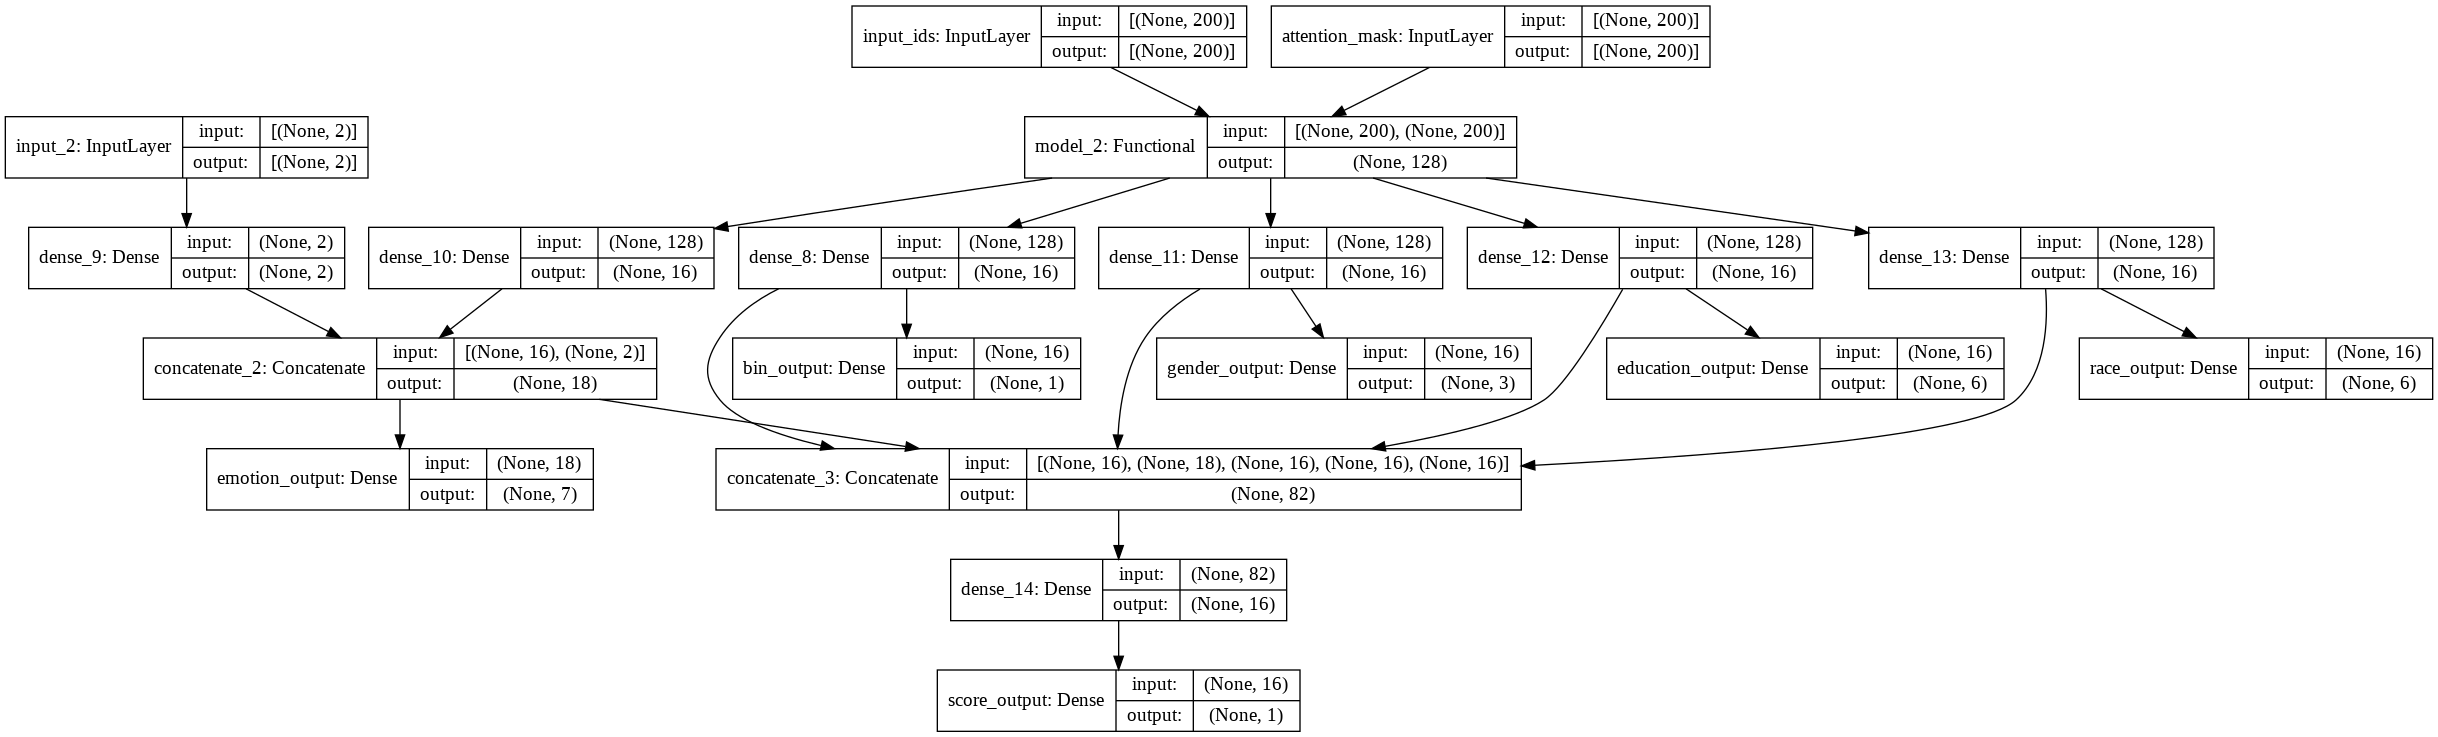

In [ ]:
model_arch = myModel.plot_model_arch()
model_arch

In [ ]:
%%time
histroy = myModel.train(prepared_train,
                        train_outputs, 
                        prepared_dev, 
                        dev_outputs,
                        epochs=200,
                        batch_size=32)

Epoch 1/200
59/59 [==============================] - 45s 569ms/step - loss: 11.9143 - bin_output_loss: 0.7303 - emotion_output_loss: 2.0235 - gender_output_loss: 1.3119 - education_output_loss: 1.6584 - race_output_loss: 1.3199 - score_output_loss: 4.6866 - score_output_mean_squared_error: 4.6866 - val_loss: 9.3426 - val_bin_output_loss: 0.6753 - val_emotion_output_loss: 1.6967 - val_gender_output_loss: 0.7583 - val_education_output_loss: 1.6335 - val_race_output_loss: 1.0385 - val_score_output_loss: 3.3558 - val_score_output_mean_squared_error: 3.3558
Epoch 2/200
59/59 [==============================] - 31s 520ms/step - loss: 9.1390 - bin_output_loss: 0.6853 - emotion_output_loss: 1.7477 - gender_output_loss: 0.7409 - education_output_loss: 1.5021 - race_output_loss: 0.9658 - score_output_loss: 3.3131 - score_output_mean_squared_error: 3.3131 - val_loss: 8.9885 - val_bin_output_loss: 0.6543 - val_emotion_output_loss: 1.6023 - val_gender_output_loss: 0.7554 - val_education_output_loss:

# Validation Data Results

In [ ]:
%%time
y_pred_dev = myModel.prediction(prepared_dev, 
                                model_path="old-empathy-bin-1-emotion-gender-edu-race-16-senti-2-score-1-16-RoBERTa-avg-128-kr-0005-mse-epoch-25-val-loss-2.640930.h5")
print(y_pred_dev.shape)

(270, 1)
CPU times: user 3.38 s, sys: 464 ms, total: 3.84 s
Wall time: 9.39 s


In [ ]:
%%time
val_mse = myModel.compute_mse(dev_outputs[-1], y_pred_dev)
print(val_mse)

2.64093
CPU times: user 1.27 ms, sys: 688 µs, total: 1.96 ms
Wall time: 7.31 ms


In [ ]:
%%time
corr = myModel.compute_correlation(dev_outputs[-1], y_pred_dev)
print("Pearson's Correlation", round(corr[0], 5))
print("P-value: ", round(corr[1], 5))

Pearson's Correlation 0.48686
P-value:  0.0
CPU times: user 1.45 ms, sys: 101 µs, total: 1.55 ms
Wall time: 6.35 ms


# Training Data Results

In [ ]:
%%time
y_pred_train = myModel.prediction(prepared_train, 
                                  model_path="old-empathy-bin-1-emotion-gender-edu-race-16-senti-2-score-1-16-RoBERTa-avg-128-kr-0005-mse-epoch-25-val-loss-2.640930.h5")
print(y_pred_train.shape)

(1860, 1)
CPU times: user 4.4 s, sys: 1.39 s, total: 5.79 s
Wall time: 24.8 s


In [ ]:
%%time
train_mse = myModel.compute_mse(train_outputs[-1], y_pred_train)
print(train_mse)

2.0034747
CPU times: user 1.46 ms, sys: 50 µs, total: 1.51 ms
Wall time: 5.94 ms


In [ ]:
%%time
corr = myModel.compute_correlation(train_outputs[-1], y_pred_train)
print("Pearson's Correlation", round(corr[0], 5))
print("P-value: ", round(corr[1], 5))

Pearson's Correlation 0.64423
P-value:  0.0
CPU times: user 1.44 ms, sys: 0 ns, total: 1.44 ms
Wall time: 1.78 ms


# Transformer model

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [ ]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [ ]:
%%time
demo_model = MTLM(base_model_type="CNN",
               cpkt="mtlm-transformer",
               activation="relu")

CPU times: user 86 µs, sys: 0 ns, total: 86 µs
Wall time: 89.6 µs


In [ ]:
%%time
prepared_train_essay, myTokenizer = demo_model.prepare_input(utils,
                                                          train_essay, 
                                                          maxlen=200, 
                                                          padding_type='post', 
                                                          truncating_type='post', 
                                                          mode="train")
print(prepared_train_essay.shape)
vocab = list(myTokenizer.word_index.keys())
print(len(vocab))

(1674, 200)
9016
CPU times: user 167 ms, sys: 0 ns, total: 167 ms
Wall time: 167 ms


In [ ]:
%%time
prepared_val_essay = demo_model.prepare_input(utils,
                                           val_essay, 
                                           maxlen=200, 
                                           padding_type='post', 
                                           truncating_type='post', 
                                           mode="test")
print(prepared_val_essay.shape)

(186, 200)
CPU times: user 13.3 ms, sys: 0 ns, total: 13.3 ms
Wall time: 12.1 ms


In [ ]:
%%time
train_outputs = demo_model.prepare_output(train_data, task="empathy", mode="train")
print(len(train_outputs))
print(train_outputs[0].shape)

val_outputs = demo_model.prepare_output(val_data, task="empathy", mode="val")
print(len(val_outputs))
print(val_outputs[0].shape)

6
(1674, 1)
6
(186, 1)
CPU times: user 3.79 ms, sys: 0 ns, total: 3.79 ms
Wall time: 4.86 ms


In [ ]:
embed_dim = 32  # Embedding size for each token
num_heads = 1  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

maxlen = 200
vocab_size = len(vocab)

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)

x1 = Dense(32, activation="relu", kernel_regularizer=l2(0.001))(x)
bin = Dense(1, activation='sigmoid', name='bin_output')(x1)
emotion_label = Dense(7, activation='softmax', name='emotion_label_output')(x1)

x2 = Dense(32, activation="relu", kernel_regularizer=l2(0.001))(x)
gender = Dense(3, activation='softmax', name='gender_output')(x2)
education = Dense(6, activation='softmax', name='education_output')(x2)
race = Dense(6, activation='softmax', name='race_output')(x2)

x3 = Dense(32, activation="relu", kernel_regularizer=l2(0.001))(x)
emotion_label = Dense(7, activation='softmax', name='emotion_label_output')(x3)

x = Concatenate(axis=1)([x1, x2, x3])
x = Dropout(0.2)(x)
x = Dense(16, activation="relu", kernel_regularizer=l2(0.001))(x)
score = Dense(1, name='score_output')(x)

# if self.base_model_type in self.bert_models:
#     self.model = Model(inputs=[input_ids, attention_mask], 
#                         outputs=[bin, gender, education, race, emotion_label, score])
# else:
model = Model(inputs=inputs, outputs=[bin, emotion_label, gender, education, race, score])
model.compile(optimizer=Adam(lr=0.001), loss={"bin_output":"binary_crossentropy",   
                                              "emotion_label_output":"sparse_categorical_crossentropy",                                                        
                                              "gender_output":"sparse_categorical_crossentropy",
                                              "education_output":"sparse_categorical_crossentropy",
                                              "race_output":"sparse_categorical_crossentropy",
                                              "score_output":"mse"})
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
token_and_position_embedding_2  (None, 200, 32)      294912      input_5[0][0]                    
__________________________________________________________________________________________________
transformer_block_2 (Transforme (None, 200, 32)      6464        token_and_position_embedding_2[0]
__________________________________________________________________________________________________
global_average_pooling1d_3 (Glo (None, 32)           0           transformer_block_2[0][0]        
____________________________________________________________________________________________

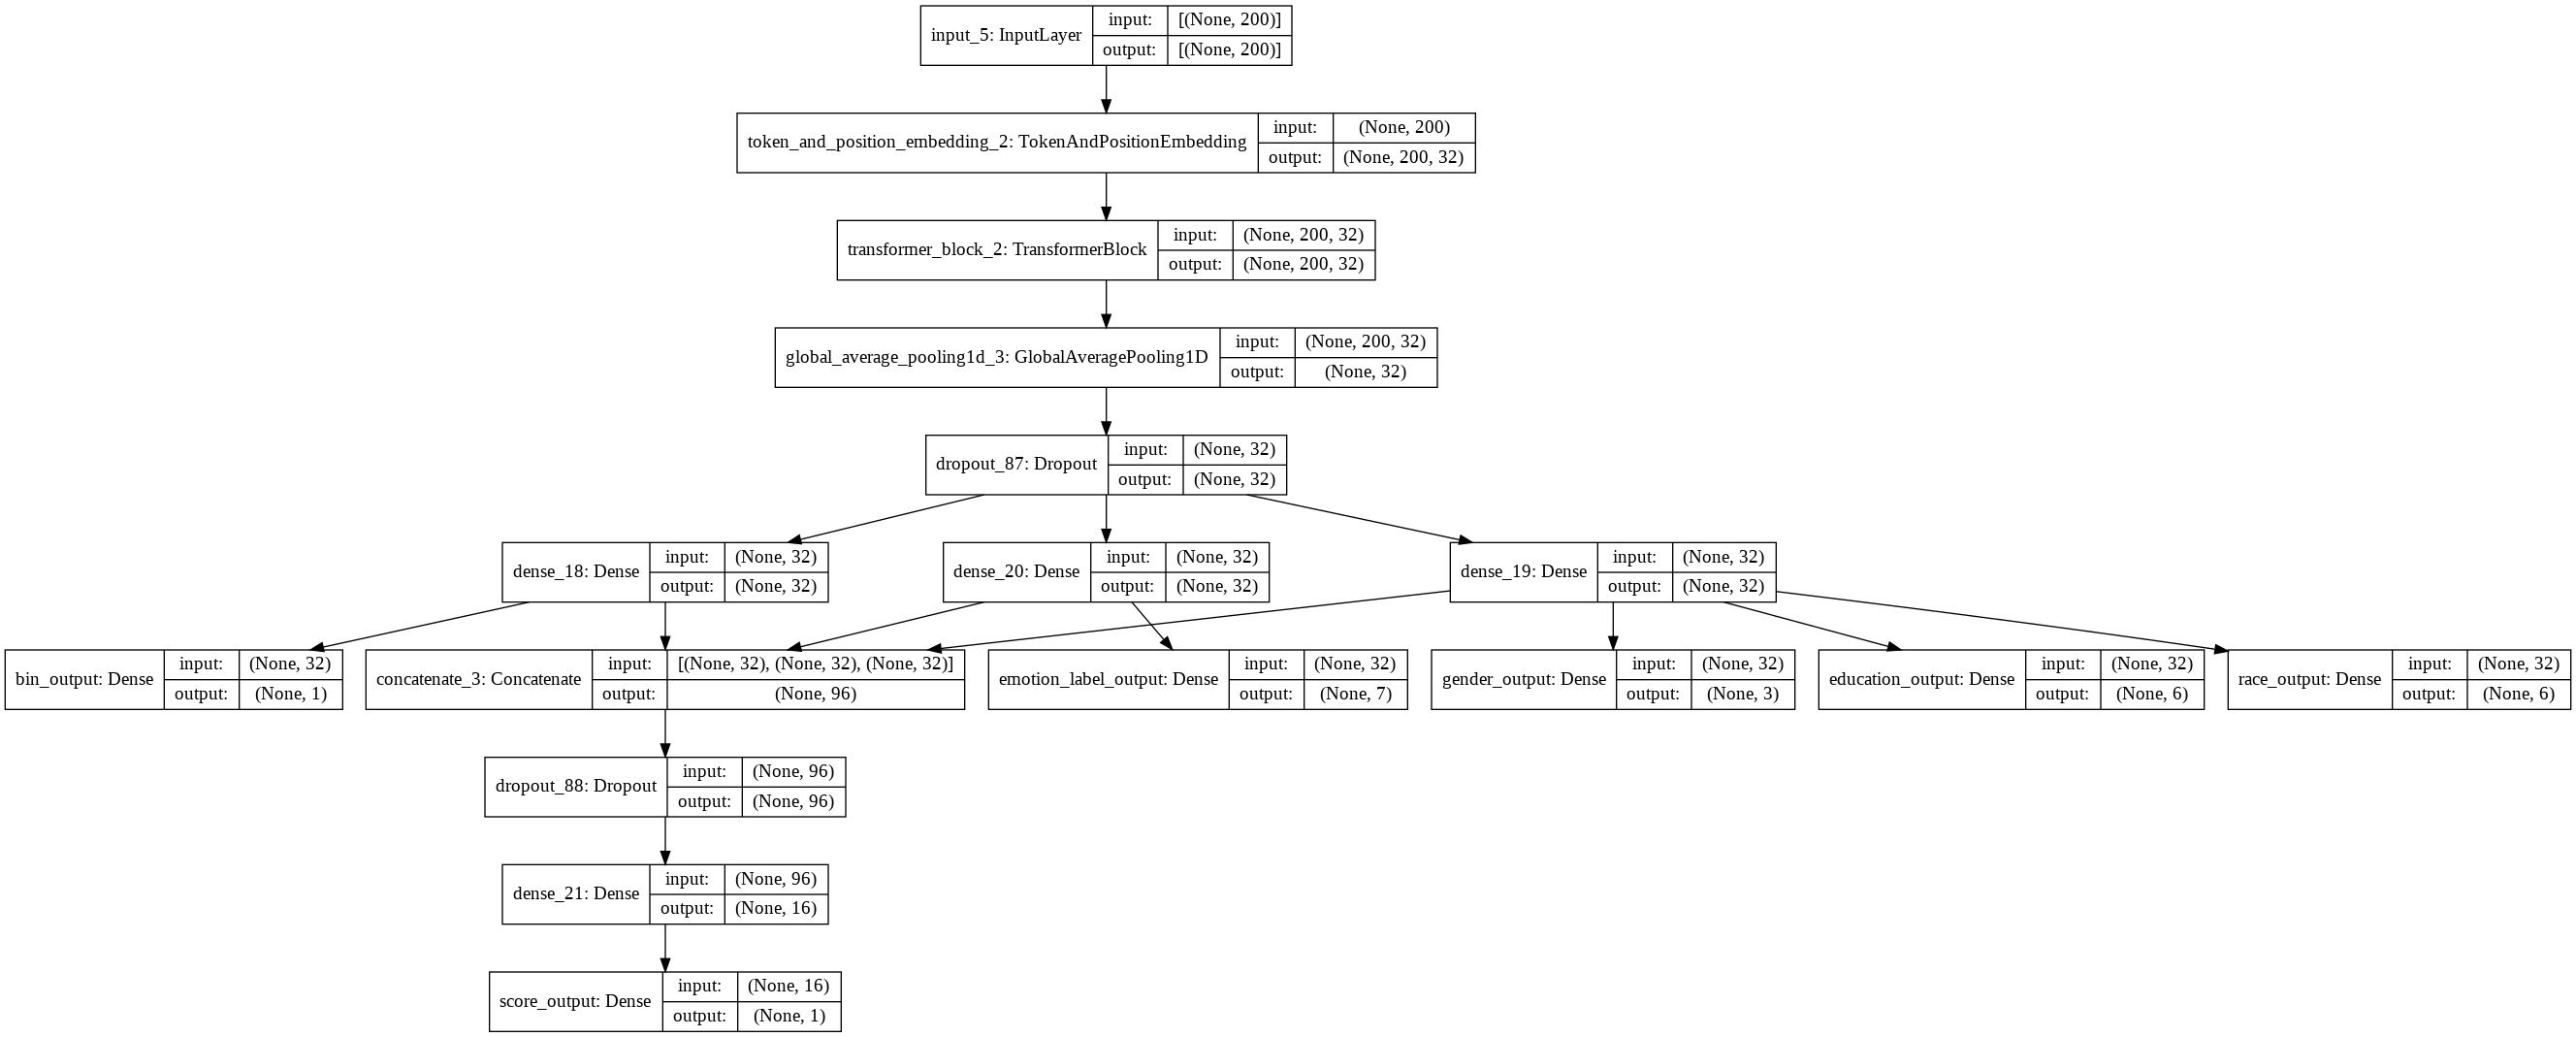

In [ ]:
plot_model(model, show_shapes=True)

In [ ]:
history = model.fit(prepared_train_essay,
                    train_outputs, 
                    epochs=200, 
                    batch_size=32, 
                    verbose=1, 
                    validation_data = (prepared_val_essay, val_outputs))

In [ ]:
model_name = "nateraw/bert-base-uncased-emotion"
# model_name = "cardiffnlp/twitter-roberta-base-sentiment"  ----> yes
#model_name = "cardiffnlp/twitter-roberta-base"
#config = AutoConfig.from_pretrained(model_name)
bert_tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=True)
bert_model = AutoModel.from_pretrained(model_name)

Some weights of the model checkpoint at nateraw/bert-base-uncased-emotion were not used when initializing BertModel: ['bert.embeddings.position_ids']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
